<a href="https://colab.research.google.com/github/sanjabh11/Projects/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

## Data preparation

#Take data from D:\Datasets ML\Datasets\Titanic

In [0]:
mkdir titanic

In [0]:
mv *.csv titanic

In [0]:
from fastai.tabular import *
path='/content/titanic'
df = pd.read_csv('titanic/train.csv')
df_test= pd.read_csv('titanic/test.csv')

In [0]:
#Segregating the numeric and categorical variable names, not needed fpr fastai

numeric_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
catgorical_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]
numeric_var_names, catgorical_var_names

In [0]:
#ver1
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Cabin', 'Embarked']
cont_names = ['Age', 'SibSp', 'Parch', 'Fare']
procs = [FillMissing, Categorify, Normalize]

In [0]:
#latest
dep_var = 'Survived'
cat_names = ['Pclass','Sex','SibSp','Embarked']
cont_names = ['Age', 'Fare']
procs = [FillMissing, Categorify, Normalize]
#'Cabin','Parch'

In [0]:
data_test = TabularList.from_df(df_test, path=path, cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           #.split_by_rand_pct(0.2)
                            .split_by_idx(valid_idx=range(len(df)-200,len(df)))
                           .label_from_df(cols=dep_var)
                           #.add_test(df_test)
                            .add_test(data_test)
                           .databunch())

In [0]:
# Way2- valid_idx = range(len(df)-200, len(df))
#data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, test_df=df_test, procs=procs, cat_names=cat_names, cont_names=cont_names)


In [0]:
data.show_batch(rows=5), 

Pclass,Sex,SibSp,Parch,Embarked,Age_na,Age,Fare,target
1,male,0,0,C,False,0.4205,-0.1182,1
3,male,0,0,Q,False,3.1468,-0.5062,0
1,female,0,2,C,False,-0.5778,0.3555,1
3,male,0,0,S,True,-0.1171,-0.5000,0
1,male,0,0,S,False,-0.1171,0.0665,1


(None,)

In [0]:
#Define function for AUC7
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [0]:
#learn = tabular_learner(data, layers=[300,200,100], metrics=accuracy) emb_drop=0.04,
learn = tabular_learner(data,layers=[100,200,300], metrics=accuracy, callback_fns=AUROC)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


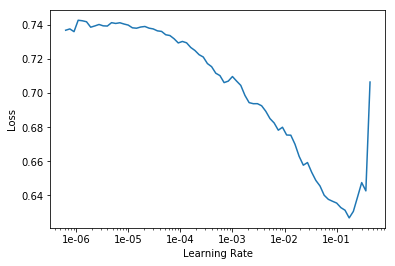

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, 1e-3)


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.713563,0.710232,0.370000,0.513889,00:00
1,0.684909,0.704165,0.370000,0.701255,00:00
2,0.666025,0.697454,0.375000,0.789414,00:00
3,0.646834,0.662406,0.670000,0.788771,00:00
4,0.617324,0.541184,0.780000,0.850654,00:00
5,0.592287,0.485627,0.790000,0.837033,00:00
6,0.570637,0.424481,0.830000,0.876394,00:00
7,0.546879,0.395357,0.835000,0.884116,00:00
8,0.527391,0.396743,0.820000,0.891731,00:00
9,0.513065,0.382873,0.860000,0.878754,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


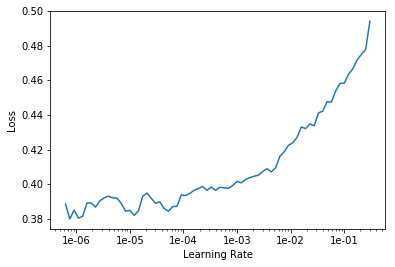

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, 7e-7)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.384551,0.349994,0.860000,0.911572,00:00
1,0.384347,0.349908,0.855000,0.911572,00:00
2,0.386349,0.346653,0.855000,0.913074,00:00
3,0.389960,0.347762,0.855000,0.913932,00:00
4,0.390343,0.346141,0.855000,0.916291,00:00
5,0.390079,0.347694,0.855000,0.913181,00:00
6,0.392544,0.348835,0.855000,0.912323,00:00
7,0.393986,0.347947,0.860000,0.911358,00:00
8,0.393386,0.346993,0.855000,0.913503,00:00
9,0.394964,0.345964,0.850000,0.913396,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


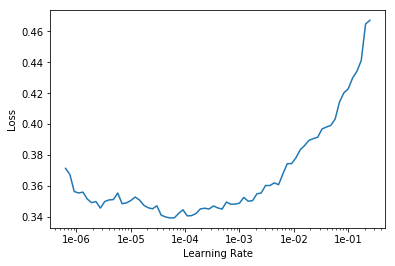

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(30, 1e-5)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.333925,0.333811,0.865000,0.928411,00:00
1,0.346213,0.334379,0.860000,0.927660,00:00
2,0.340787,0.333930,0.865000,0.930019,00:00
3,0.347733,0.334809,0.860000,0.929161,00:00
4,0.343988,0.335750,0.860000,0.928625,00:00
5,0.342053,0.337492,0.865000,0.926695,00:00
6,0.344551,0.334813,0.865000,0.928840,00:00
7,0.341404,0.334709,0.860000,0.929912,00:00
8,0.339388,0.333632,0.865000,0.928840,00:00
9,0.335235,0.334646,0.865000,0.927874,00:00


In [0]:
learn.save('stage-3_titanic')

In [0]:
learn.load("stage-3_titanic")

learn.validate()

In [0]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

array([0, 1, 2, 3, ..., 709, 710, 711, 712], dtype=object)

In [0]:
labels

In [0]:
res_df = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': labels})
res_df.to_csv('titanic_submission.csv', index=False)

(Category 0, tensor(0), tensor([0.8324, 0.1676]))



```
# This is formatted as code
```

###Data Cleaning / Feature Engineering

In [0]:
len(df),len(df_test)

(891, 418)

In [0]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
for df in (train,test):
    df['Age'] = df.Age.fillna(0).astype(np.int32)
    df["Name_mod"] = df["Name"].str.replace('[^\w\s]','')
    df["Ticket_mod"] = df["Ticket"].str.replace('[^\w\s]','')
    df["Name_mod"] = df["Name_mod"].str.upper()
    df["Ticket_mod"] = df["Ticket_mod"].str.upper()
    df["Ticket_mod"]=df["Ticket_mod"].str.upper()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_mod,Ticket_mod
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,BRAUND MR OWEN HARRIS,A5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,CUMINGS MRS JOHN BRADLEY FLORENCE BRIGGS THAYER,PC 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,HEIKKINEN MISS LAINA,STONO2 3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,FUTRELLE MRS JACQUES HEATH LILY MAY PEEL,113803
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,ALLEN MR WILLIAM HENRY,373450


In [0]:
def returnSelectedWord(in_str,selected_words):
	a=in_str.split()
	out = ""
	if any(i in a for i in selected_words):
		out = list(set(a) & set(selected_words))[0]
	return out
	
selected_words = ['MR','MISS','MRS','MASTER','MS','DR'] 
for df in (train,test):
    df["Title"]=df["Name_mod"].apply( lambda x: returnSelectedWord( x,selected_words) )


In [0]:
import re

def returnAlpha(text):
    match = re.search(r'\(?([A-Z]+)\)?', text)
    if match is None:
        return ''
    else:
        return match.group(1)
def returnNumeric(text):
    tmp = text.split()
    text2 =tmp[tmp.__len__()-1]
    match = re.search(r'\(?([0-9]+)\)?', text2)
    if match is None:
        return ''
    else:
        return match.group(1)
for df in (train,test):
    df["Ticket_Alpha_shrt"]=df["Ticket_mod"].apply( lambda x: returnAlpha(x)[:2] )
    df["Ticket_Numeric_shrt"]=df["Ticket_mod"].apply( lambda x: returnNumeric(x)[:2] )
    df["Ticket_Numeric_len"]=df["Ticket_mod"].apply( lambda x: len(returnNumeric(x)) )

In [0]:
for df in (train,test):
    df["Fare"]=df["Fare"]+.0001
train.Survived = train.Survived.astype(int)

In [0]:
for df in (train,test):
    df["Cabin_cnt"]=df["Cabin"].apply(lambda x: '' if pd.isnull(x) else len(x.split()) )
    df["Cabin_mod"]=df["Cabin"].apply(lambda x: '' if pd.isnull(x) else returnAlpha(x)[:2] )
    df["Cabin_num"]=df["Cabin"].apply(lambda x: '' if pd.isnull(x) else returnNumeric(x))
    df["Cabin_num_sm"] = df.Cabin_num.apply(lambda x: -1 if x=='' else str(int(int(x)/10)))
    df["Name_cnt"] = df["Name_mod"].apply(lambda x: 0 if pd.isnull(x) else len(x.split()) )
    df["Fare_log"] = df["Fare"].apply(lambda x: -10.0 if x==0 else math.log(x))

train[["PassengerId","Pclass", "Sex","SibSp","Parch","Title","Ticket_Alpha_shrt","Ticket_Numeric_shrt","Ticket_Numeric_len","Cabin_cnt","Cabin_mod","Cabin_num_sm","Name_cnt","Embarked","Fare","Fare_log","Age","Survived"]].head()

,PassengerId,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_cnt,Cabin_mod,Cabin_num_sm,Name_cnt,Embarked,Fare,Fare_log,Age,Survived
0,1,3,male,1,0,MR,A,21,5,,,-1,4,S,7.2501,1.981015,22,0
1,2,1,female,1,0,MRS,PC,17,5,1,C,8,7,C,71.2834,4.266663,38,1
2,3,3,female,0,0,MISS,ST,31,7,,,-1,3,S,7.9251,2.070035,26,1
3,4,1,female,1,0,MRS,,11,6,1,C,12,7,S,53.1001,3.972179,35,1
4,5,3,male,0,0,MR,,37,6,,,-1,4,S,8.0501,2.085685,35,0


In [0]:
df.head().T.head(40)


,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [0]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
cat_vars = ["Pclass", "Sex","SibSp","Parch","Title","Ticket_Alpha_shrt","Ticket_Numeric_shrt","Ticket_Numeric_len","Cabin_num_sm","Cabin_cnt","Cabin_mod","Name_cnt","Embarked"]
drop_vars = ["Fare","Name","Ticket","Cabin"]
contin_vars = ["Fare_log","Age"]
index = 'PassengerId'
n = len(train); n
for df in (test,train):
    df.set_index(index)

In [0]:
dep = 'Survived'

train = train[cat_vars+contin_vars+[dep, 'PassengerId']].copy()

In [0]:
test[dep] = 0
test = test[cat_vars+contin_vars+[dep, 'PassengerId']].copy()

In [0]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()


In [0]:
apply_cats(test, train)

In [0]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

In [0]:
samp_size = n
train_samp = df.set_index("PassengerId")
n

In [0]:
train_samp.head(2)

,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_num_sm,Cabin_cnt,Cabin_mod,Name_cnt,Embarked,Fare_log,Age,Survived
PassengerId,,,,,,,,,,,,,,,,
1,3,male,1,0,MR,A,21,5,-1,,,4,S,1.981015,22.0,0
2,1,female,1,0,MRS,PC,17,5,8,1,C,7,C,4.266664,38.0,1


## Model

In [0]:
max_log_y = np.log(np.max(df['Survived'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
#learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(130, 24)
    (3): Embedding(4, 3)
    (4): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=40, out_features=100, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=300, out_features=2, bias=True)
  )
)

In [0]:
#len(data.train_ds.cont_names), len(data.test_ds.cont_names), 
len(df_test), len(df)

(418, 891)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


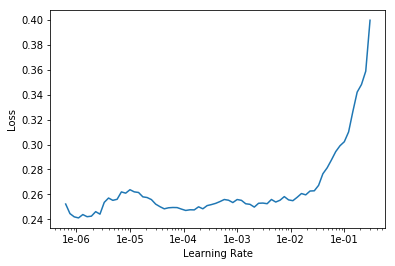

In [0]:
learn.unfreeze
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 7e-07)

epoch,train_loss,valid_loss,accuracy,time
0,0.261042,0.525963,0.814607,00:00
1,0.255812,0.520323,0.808989,00:00
2,0.257092,0.520079,0.808989,00:00
3,0.256665,0.517329,0.808989,00:00
4,0.257850,0.530299,0.808989,00:00
5,0.254898,0.522197,0.808989,00:00
6,0.255082,0.526208,0.808989,00:00
7,0.252728,0.516946,0.808989,00:00
8,0.250701,0.520917,0.808989,00:00
9,0.251187,0.523868,0.814607,00:00


In [0]:
learn.save('1')

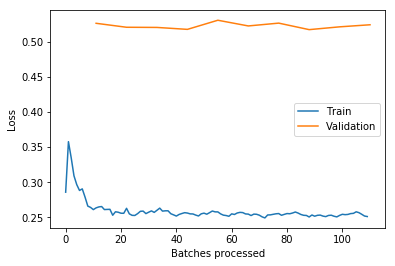

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load('1');

In [0]:
learn.fit_one_cycle(5, 7e-06)

epoch,train_loss,valid_loss,accuracy,time
0,0.240865,0.579751,0.808989,00:00
1,0.239802,0.584963,0.803371,00:00
2,0.241154,0.580105,0.808989,00:00
3,0.240991,0.584295,0.797753,00:00
4,0.244783,0.584064,0.797753,00:00


In [0]:
learn.fit_one_cycle(5, 1e-06)

epoch,train_loss,valid_loss,accuracy,time
0,0.237903,0.584769,0.792135,00:00
1,0.239663,0.579145,0.808989,00:00
2,0.239523,0.585293,0.803371,00:00
3,0.239006,0.582343,0.808989,00:00
4,0.239687,0.582100,0.803371,00:00


If the results getting detioriated load stage 1

In [0]:
learn.load("stage-1")

learn.validate()

In [0]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [0]:
res_df = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': labels})
res_df.to_csv('titanic_submission.csv', index=False)

In [0]:
#f you have added the test set to the data, you can then call
learn.get_preds (DatasetType.Test )

torch.Size([418])